In [2]:
import import_ipynb

import os
import math
import random
import itertools
import numpy as np
from tqdm import tqdm
from IPython import display
from threading import Thread
from multiprocessing import Manager, Queue
from typing import Optional, List, Dict, Tuple
from tqdm.contrib.concurrent import process_map
from custom_types import Vertex, CostFunction, Cost, Solution, Solver, Evaluation, Graph, Optimizer
from generate_sample_graphs import serialize_graphs, deserialize_graphs, draw_graph, generate_random_graph

importing Jupyter notebook from generate_sample_graphs.ipynb


In [3]:
if __name__ == "__main__":
  sample_graphs_path = "sample_graphs.dat"
  if os.path.exists(sample_graphs_path):
    with open(sample_graphs_path, "r+b") as fp:
      sample_graphs, _ = deserialize_graphs(fp)

  print(f"Got {len(sample_graphs)} sample graphs")

Got 10000 sample graphs


In [4]:
if __name__ == "__main__":
  small_sample_graph = generate_random_graph(min_num_vertices=6,max_num_vertices=6)

In [5]:
def is_valid_solution(graph: Graph, solution: Solution) -> bool:
  vertices, _ = graph
  for v in vertices:
    if v not in solution:
      return False
  return True

In [6]:
def cost_of_solution(graph: Graph, solution: Solution) -> Cost:
  _, cost_function = graph
  cost = cost_function[solution[0]][solution[-1]]
  for i, v in enumerate(solution[:-1]):
    cost += cost_function[v][solution[i+1]]
  return cost

In [7]:
def list_of_edges_to_tour(edges: List[Tuple[Vertex, Vertex, Cost]]) -> Solution:
  
  solution: Solution = [edges[0][0]]

  used_edge: Dict[int, bool] = {0: True}
  for i in range(1, len(edges)):
    used_edge[i] = False

  while len(solution) < len(edges):
    for i, edge in enumerate(edges):
      if used_edge[i]:
        continue
      if edge[0] == solution[0]:
        solution = [edge[1]]+solution
      elif edge[1] == solution[0]:
        solution = [edge[0]]+solution
      elif edge[0] == solution[-1]:
        solution.append(edge[1])
      elif edge[1] == solution[-1][1]:
        solution.append(edge[0])
      else:
        continue
      used_edge[i] = True
  
  return solution


In [8]:
def bfs(vertices: List[Vertex], edges: List[Tuple[Vertex, Vertex, Cost]], start: Vertex, end: Vertex) -> Optional[List[Vertex]]:
  visited: Dict[Vertex, bool] = {}
  for v in vertices:
    visited[v] = False

  queue: List[List[Vertex]] = [[start]]


  while len(queue) > 0:
    path = queue[0]
    current = path[-1]
    queue = queue[1:]

    if current == end:
      return path

    visited[current] = True
    for edge in edges:
      if edge[0] == current and not visited[edge[1]]:
        queue.append(path+[edge[1]])
      elif edge[1] == current and not visited[edge[0]]:
        queue.append(path+[edge[0]])

  return None


def contains_minor_cycle(vertices: List[Vertex], edges: List[Tuple[Vertex, Vertex, Cost]]) -> bool:
  for i, edge in enumerate(edges):
    path = bfs(vertices, edges[:i]+edges[i+1:], edge[0], edge[1])
    if path is not None and len(path) < len(vertices):
      return True
  return False


['V4', 'V0', 'V1', 'V5', 'V2', 'V3']
1.6486767642906526


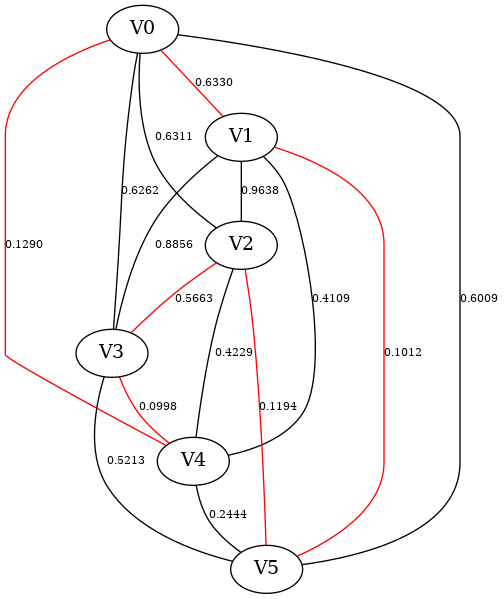

In [9]:
greedy: Solver
def greedy(graph: Graph) -> Solution:
  vertices, cost_function = graph

  all_edges: List[Tuple[Vertex, Vertex, Cost]] = []
  for v in vertices:
    all_edges += ((v, *e) for e in cost_function[v].items() if v < e[0])
  all_edges = list(sorted(all_edges, key=lambda edge: edge[2]))

  vertex_degree: Dict[Vertex, int] = {}
  for v in vertices:
    vertex_degree[v] = 0

  edges: List[Tuple[Vertex, Vertex, Cost]] = []
  while len(edges) < len(vertices):
    for i, edge in enumerate(all_edges):
      if contains_minor_cycle(vertices, edges+[edge]):
        continue
      if vertex_degree[edge[0]] >= 2 or vertex_degree[edge[1]] >= 2:
        continue
      edges.append(edge)
      del all_edges[i]
      vertex_degree[edge[0]] += 1
      vertex_degree[edge[1]] += 1
      break
    else:
      raise AssertionError("Ran out of edges")
  
  return list_of_edges_to_tour(edges)

if __name__ == "__main__":
  solution = greedy(small_sample_graph)
  print(solution)
  assert is_valid_solution(small_sample_graph, solution)
  print(cost_of_solution(small_sample_graph, solution))
  display.display(draw_graph(small_sample_graph, highlight=solution))

['V0', 'V4', 'V3', 'V5', 'V1', 'V2']
2.4462255818844216


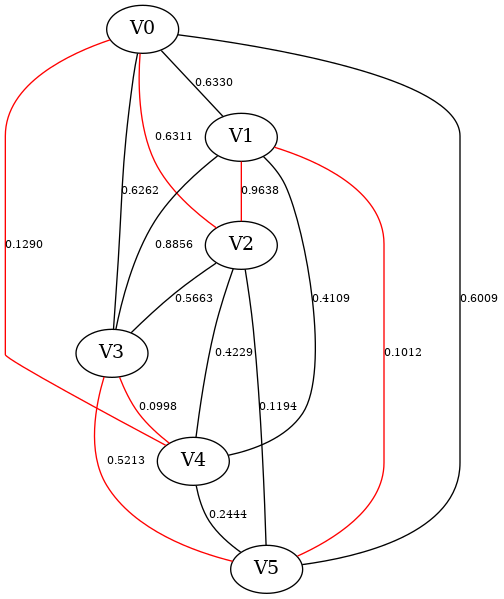

In [10]:
nearest_neighbor: Solver
def nearest_neighbor(graph: Graph) -> Solution:
  vertices, cost_function = graph

  is_visited: Dict[Vertex, bool] = {}
  for v in vertices:
    is_visited[v] = False
  
  current = vertices[0]
  solution: List[Vertex] = [current]

  while len(solution) < len(vertices):
    is_visited[current] = True
    adjacent = cost_function[current].items()
    available = [edge for edge in adjacent if not is_visited[edge[0]]]
    assert len(available) > 0, "Ran out of edges"
    current = min(available, key=lambda edge: edge[1])[0]
    solution.append(current)

  return solution

if __name__ == "__main__":
  solution = nearest_neighbor(small_sample_graph)
  print(solution)
  assert is_valid_solution(small_sample_graph, solution)
  print(cost_of_solution(small_sample_graph, solution))
  display.display(draw_graph(small_sample_graph, highlight=solution))

['V0', 'V3', 'V2', 'V5', 'V1', 'V4']
1.9530539949791694


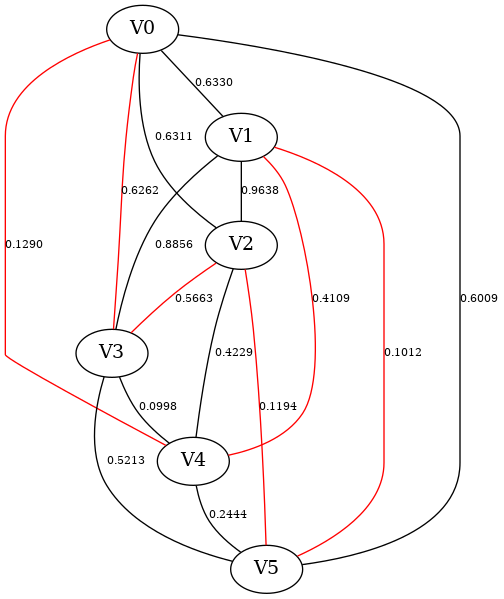

In [11]:
nearest_insertion: Solver
def nearest_insertion(graph: Graph) -> Solution:
  vertices, cost_matrix = graph

  solution: Solution = [vertices[0], vertices[1]]

  while len(solution) < len(vertices):  
    min_new_vertex = None
    min_new_vertex_dst = 0
    for v in vertices:
      if v in solution:
        continue
      
      for t in solution:
        dst = cost_matrix[t][v]
        if min_new_vertex is None or dst < min_new_vertex_dst:
          min_new_vertex = v
          min_new_vertex_dst = dst
  
    assert min_new_vertex is not None

    min_new_vertex_cost = 0
    min_new_vertex_idx = -1
    for i, tx in enumerate(solution):
      ty = solution[(i+1)%len(solution)]
      existing_cost = cost_matrix[tx][ty]
      new_cost = cost_matrix[tx][min_new_vertex] + cost_matrix[min_new_vertex][ty]
      additional_cost = new_cost-existing_cost
      if min_new_vertex_idx < 0 or additional_cost < min_new_vertex_cost:
        min_new_vertex_cost = additional_cost
        min_new_vertex_idx = i+1
    
    assert min_new_vertex_idx >= 0

    solution = solution[:min_new_vertex_idx] + [min_new_vertex] + solution[min_new_vertex_idx:]
  
  return solution

if __name__ == "__main__":
  solution = nearest_insertion(small_sample_graph)
  print(solution)
  assert is_valid_solution(small_sample_graph, solution)
  print(cost_of_solution(small_sample_graph, solution))
  display.display(draw_graph(small_sample_graph, highlight=solution))

['V0', 'V4', 'V3', 'V2', 'V5', 'V1']
1.6486767642906524


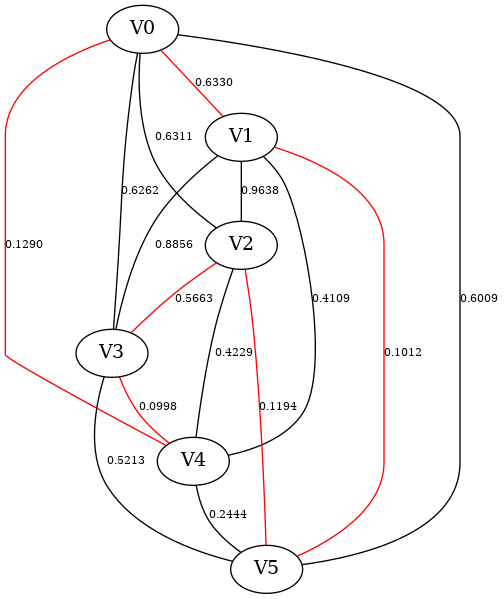

In [12]:
cheapest_insertion: Solver
def cheapest_insertion(graph: Graph) -> Solution:
  vertices, cost_matrix = graph
  
  solution: Solution = [vertices[0], vertices[1]]

  while len(solution) < len(vertices):  
    min_new_vertex = None
    min_new_vertex_cost = 0
    min_new_vertex_idx = 0
    for v in vertices:
      if v in solution:
        continue
      
      for i, tx in enumerate(solution):
        ty = solution[(i+1)%len(solution)]
        existing_cost = cost_matrix[tx][ty]
        new_cost = cost_matrix[tx][v] + cost_matrix[v][ty]
        additional_cost = new_cost-existing_cost
        if min_new_vertex is None or additional_cost < min_new_vertex_cost:
          min_new_vertex = v
          min_new_vertex_cost = additional_cost
          min_new_vertex_idx = i+1
  
    assert min_new_vertex is not None

    solution = solution[:min_new_vertex_idx] + [min_new_vertex] + solution[min_new_vertex_idx:]

  return solution

if __name__ == "__main__":
  solution = cheapest_insertion(small_sample_graph)
  print(solution)
  assert is_valid_solution(small_sample_graph, solution)
  print(cost_of_solution(small_sample_graph, solution))
  display.display(draw_graph(small_sample_graph, highlight=solution))

['V0', 'V4', 'V3', 'V2', 'V5', 'V1']
1.6486767642906524


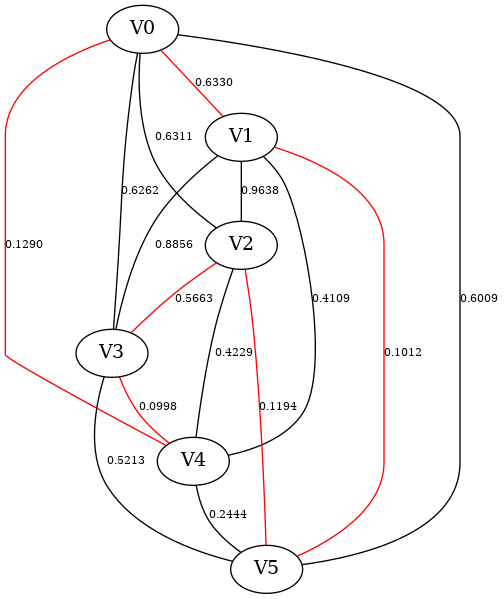

In [13]:
random_insertion: Solver
def random_insertion(graph: Graph) -> Solution:
  vertices, cost_matrix = graph
  solution: Solution = [vertices[0], vertices[1]]

  random.seed(int.from_bytes(os.urandom(4), byteorder='little'))

  while len(solution) < len(vertices):
    new_vertex = random.choice([v for v in vertices if v not in solution])
    min_new_vertex_cost = 0
    min_new_vertex_idx = -1
    for i, tx in enumerate(solution):
      ty = solution[(i+1)%len(solution)]
      existing_cost = cost_matrix[tx][ty]
      new_cost = cost_matrix[tx][new_vertex] + cost_matrix[new_vertex][ty]
      additional_cost = new_cost-existing_cost
      if min_new_vertex_idx < 0 or additional_cost < min_new_vertex_cost:
        min_new_vertex_cost = additional_cost
        min_new_vertex_idx = i+1
    
    assert min_new_vertex_idx >= 0

    solution = solution[:min_new_vertex_idx] + [new_vertex] + solution[min_new_vertex_idx:]

  return solution

if __name__ == "__main__":
  solution = random_insertion(small_sample_graph)
  print(solution)
  assert is_valid_solution(small_sample_graph, solution)
  print(cost_of_solution(small_sample_graph, solution))
  display.display(draw_graph(small_sample_graph, highlight=solution))

['V0', 'V2', 'V3', 'V4', 'V5', 'V1']
2.275763266979055


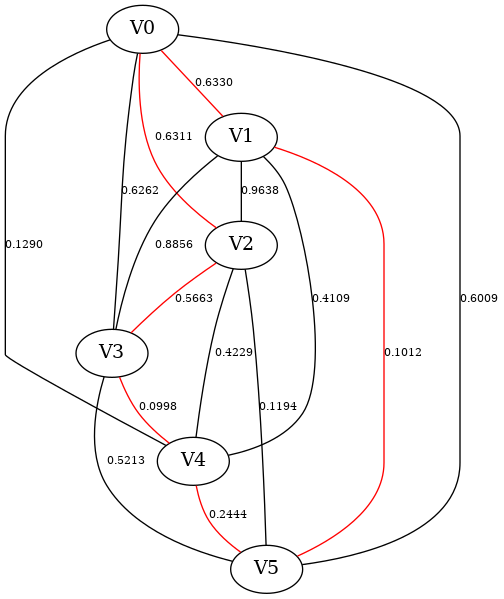

In [14]:
farthest_insertion: Solver
def farthest_insertion(graph: Graph) -> Solution:
  vertices, cost_matrix = graph
  solution: Solution = [vertices[0], vertices[1]]

  while len(solution) < len(vertices):  
    max_new_vertex = None
    max_new_vertex_dst = 0
    for v in vertices:
      if v in solution:
        continue
      
      for t in solution:
        dst = cost_matrix[t][v]
        if max_new_vertex is None or dst > max_new_vertex_dst:
          max_new_vertex = v
          max_new_vertex_dst = dst
  
    assert max_new_vertex is not None

    min_new_vertex_cost = 0
    min_new_vertex_idx = -1
    for i, tx in enumerate(solution):
      ty = solution[(i+1)%len(solution)]
      existing_cost = cost_matrix[tx][ty]
      new_cost = cost_matrix[tx][max_new_vertex] + cost_matrix[max_new_vertex][ty]
      additional_cost = new_cost-existing_cost
      if min_new_vertex_idx < 0 or additional_cost < min_new_vertex_cost:
        min_new_vertex_cost = additional_cost
        min_new_vertex_idx = i+1
    
    assert min_new_vertex_idx >= 0

    solution = solution[:min_new_vertex_idx] + [max_new_vertex] + solution[min_new_vertex_idx:]

  return solution

if __name__ == "__main__":
  solution = farthest_insertion(small_sample_graph)
  print(solution)
  assert is_valid_solution(small_sample_graph, solution)
  print(cost_of_solution(small_sample_graph, solution))
  display.display(draw_graph(small_sample_graph, highlight=solution))

['V4', 'V0', 'V1', 'V5', 'V2', 'V3']
1.6486767642906526


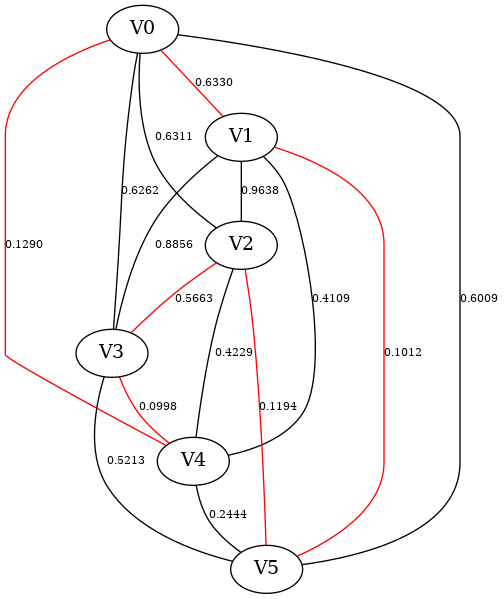

In [15]:
two_opt: Optimizer
def two_opt(solver: Solver) -> Solver:
  def improved_solver(graph: Graph) -> Solution:
    vertices, cost_matrix = graph    

    solution = solver(graph)

    improved = True
    while improved:
      improved = False
      for i, u1 in enumerate(solution):
        for j in range(i+2, len(solution)):
          v1 = solution[(i+1)%len(solution)]
          u2 = solution[j]
          v2 = solution[(j+1)%len(solution)]
          existing_cost = cost_matrix[u1][v1] + cost_matrix[v1][v2]
          new_cost = cost_matrix[u1][u2] + cost_matrix[v1][v2]
          delta = new_cost - existing_cost
          if delta < -1e14:
            improved = True
            solution[(i+1)%len(solution)] = u1
            solution[j] = v1
            break
        if improved:
          break

    return solution

  improved_solver.__name__ = f"2-Opt<{solver.__name__}>"
  return improved_solver

if __name__ == "__main__":
  solution = two_opt(greedy)(small_sample_graph)
  print(solution)
  assert is_valid_solution(small_sample_graph, solution)
  print(cost_of_solution(small_sample_graph, solution))
  display.display(draw_graph(small_sample_graph, highlight=solution))

In [18]:
if __name__ == "__main__":
  def evaluate(args: "Tuple[Solver, Optional[Optimizer], Graph, Queue[Tuple[str, Optional[Evaluation]]]]") -> Evaluation:
    solver, optimizer, graph, q = args
    solution = solver(graph) if optimizer is None else optimizer(solver)(graph)
    assert is_valid_solution(graph, solution), f"\n{solver.__name__}\n{optimizer.__name__ if optimizer is not None else None}\n{str(graph)}\n{str(solution)}\n"
    cost = cost_of_solution(graph, solution)
    evaluation = (solver, optimizer, graph, solution, cost)
    q.put(("EVALUATION", evaluation))
    return evaluation
      
  def listener(path: str, q: "Queue[Tuple[str, Optional[Evaluation]]]", evaluations: "List[Evaluation]"):
    while True:
      cmd, arg = q.get()
      if cmd == "STOP":
        break
      elif cmd == "EVALUATION":
        evaluations.append(arg)
        _, __, graph, solution, ___ = arg
        with open(path, "wb" if len(evaluations) == 1 else "ab") as fp:
          if len(evaluations) > 1:
            fp.write(b"\n")
          serialize_graphs(fp, graph, (solution, graph[1]))
      else:
        raise AssertionError(f"Unknown command: {cmd}")
    
  solvers = [greedy, nearest_insertion, cheapest_insertion, random_insertion, farthest_insertion]
  optimizers = [two_opt]
  optimized_solvers = []
  for opt in optimizers:
    for solver in solvers:
      optimized_solvers.append((opt, solver))
  graphs_to_evaluate = sample_graphs
  to_evaluate: "List[Tuple[Solver, Optional[Optimizer], Graph, Queue[Tuple[str, Optional[Evaluation]]]]]" = []
  evaluations: Dict[str, List[Evaluation]] = {}

  evaluations_dir = "evaluations"
  if not os.path.exists(evaluations_dir):
    os.makedirs(evaluations_dir)

  manager = Manager()
  queues: "Dict[str, Queue[Tuple[str, Optional[Evaluation]]]]" = {}

  threads: List[Thread] = []

  for solver_or_optimized in solvers+optimized_solvers:
    is_optimized = type(solver_or_optimized) == tuple
    solver = solver_or_optimized[0](solver_or_optimized[1]) if is_optimized else solver_or_optimized
    pair = solver_or_optimized if is_optimized else (None, solver)
    q: "Queue[Tuple[str, Optional[Evaluation]]]" = manager.Queue()
    queues[solver.__name__] = q

    array: List[Evaluation] = []
    evaluations[solver.__name__] = array

    path = os.path.join(evaluations_dir, f"{solver.__name__}.dat")

    if os.path.exists(path):
      with open(path, "r+b") as fp:
        graphs, graph_end_positions = deserialize_graphs(fp)
        for i in range(0, len(graphs)-1, 2):
          graph = graphs[i]
          solution = graphs[i+1][0]
          array.append((pair[1], pair[0], graph, solution, cost_of_solution(graph, solution)))

        if len(graph_end_positions) == 0:
          fp.seek(0)
        else:
          fp.seek(graph_end_positions[len(graph_end_positions)//2 * 2 - 1])
        fp.truncate()
    
    already_evaluated_graphs = list(e[2] for e in array)
    still_to_evaluate = list(g for g in graphs_to_evaluate if g not in already_evaluated_graphs)

    print(f"{solver.__name__}: [{len(already_evaluated_graphs)}/{len(graphs_to_evaluate)}] ({100*(len(already_evaluated_graphs)/len(graphs_to_evaluate)):.2f}%) graphs evaluated")
    
    to_evaluate += list(zip(itertools.repeat(pair[1]), itertools.repeat(pair[0]), still_to_evaluate, itertools.repeat(q)))
    new_thread = Thread(target=listener, args=(path, q, array), daemon=True)
    new_thread.start()
    threads.append(new_thread)

  total_num_to_evaluate = (len(solvers)+len(optimized_solvers))*len(graphs_to_evaluate)
  total_num_evaluated = total_num_to_evaluate - len(to_evaluate)
  print(f"\nTotal: [{total_num_evaluated}/{total_num_to_evaluate}] ({100*(total_num_evaluated/total_num_to_evaluate):.2f}%) graphs evaluated")

  if len(to_evaluate) > 0:
    process_map(evaluate, to_evaluate, max_workers=10, tqdm_class=tqdm, chunksize=1000)


  for q in queues.values():
    q.put(("STOP", None))
  
  for thread in threads:
    thread.join()
  
  if len(to_evaluate) > 0:
    for solver in solvers:
        already_evaluated_graphs = list(e[2] for e in evaluations[solver.__name__])
        print(f"{solver.__name__}: [{len(already_evaluated_graphs)}/{len(graphs_to_evaluate)}] ({100*(len(already_evaluated_graphs)/len(graphs_to_evaluate)):.2f}%) graphs evaluated")

greedy: [10000/10000] (100.00%) graphs evaluated
nearest_insertion: [10000/10000] (100.00%) graphs evaluated
cheapest_insertion: [10000/10000] (100.00%) graphs evaluated
random_insertion: [10000/10000] (100.00%) graphs evaluated
farthest_insertion: [10000/10000] (100.00%) graphs evaluated
2-Opt<greedy>: [10000/10000] (100.00%) graphs evaluated
2-Opt<nearest_insertion>: [10000/10000] (100.00%) graphs evaluated
2-Opt<cheapest_insertion>: [10000/10000] (100.00%) graphs evaluated
2-Opt<random_insertion>: [10000/10000] (100.00%) graphs evaluated
2-Opt<farthest_insertion>: [10000/10000] (100.00%) graphs evaluated

Total: [100000/100000] (100.00%) graphs evaluated
